<a href="https://colab.research.google.com/github/pgilll/Reinforcement-Learning-Final-Project/blob/main/RL_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import modules and environment
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make('CliffWalking-v1', is_slippery=False, render_mode="rgb_array")

array([[[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 98, 166, 105],
        ...,
        [105, 182,  74],
        [105, 182,  74],
        [ 86, 170,  69]],

       ...,

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]]], dtype=uint8)
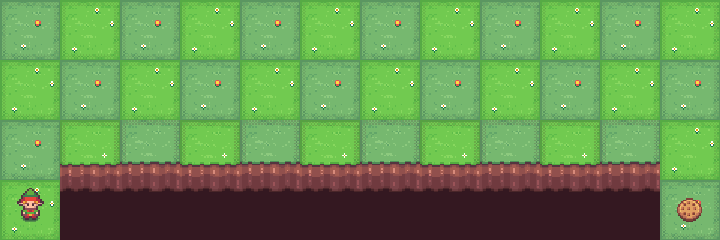

In [32]:
# Reset and render environment
state, info = env.reset()
env.render()

# Model Based

In [33]:
# Implement Value Iteration
def value_iteration(env, gamma=0.9, theta=1e-4):
  V = np.zeros((48,))
  policy = np.zeros((48,))
  iteration = 0
  deltas = []
  while True:
    delta = 0
    for state in range(47):
      state_value = V[state]
      actionValues = []
      for action in range(4):
        action_value = 0
        for prob, next_state, reward, done in env.unwrapped.P[state][action]:
          action_value += prob * (reward + gamma * V[next_state])
          actionValues.append(action_value)
      V[state] = max(actionValues)
      delta = max(delta, abs(state_value - V[state]))
      policy[state] = np.argmax(actionValues)
    iteration += 1
    deltas.append(delta)
    if delta < theta:
      break
  print(iteration, "iterations")
  return V, policy, deltas

In [34]:
# Run environment with value iteration
V, policy, deltas = value_iteration(env)
print(V.reshape(4, 12))
print(policy.reshape(4, 12))

15 iterations
[[-7.71232075 -7.45813417 -7.17570464 -6.86189404 -6.5132156  -6.12579511
  -5.6953279  -5.217031   -4.68559    -4.0951     -3.439      -2.71      ]
 [-7.45813417 -7.17570464 -6.86189404 -6.5132156  -6.12579511 -5.6953279
  -5.217031   -4.68559    -4.0951     -3.439      -2.71       -1.9       ]
 [-7.17570464 -6.86189404 -6.5132156  -6.12579511 -5.6953279  -5.217031
  -4.68559    -4.0951     -3.439      -2.71       -1.9        -1.        ]
 [-7.45813417 -7.17570464 -6.86189404 -6.5132156  -6.12579511 -5.6953279
  -5.217031   -4.68559    -4.0951     -3.439      -1.          0.        ]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [37]:
# Display learned V-values
def v_directions_map(V, policy, env):
  directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  V_reshaped = V.reshape(4, 12)
  v_directions = np.array([directions[a] for a in policy], dtype=str).reshape(4, 12)

  # Plot the last frame
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  ax[0].imshow(env.render())
  ax[0].axis("off")
  ax[0].set_title("Last frame")

  # Plot the policy
  sns.heatmap(
      V_reshaped,
      annot=v_directions,
      fmt="",
      ax=ax[1],
      cmap=sns.color_palette("Greens", as_cmap=True),
      linewidths=0.7,
      linecolor="black",
      xticklabels=[],
      yticklabels=[],
      annot_kws={"fontsize": "xx-large"},
  ).set(title="Learned V-values\nArrows represent best action")
  for _, spine in ax[1].spines.items():
      spine.set_visible(True)
      spine.set_linewidth(0.7)
      spine.set_color("black")
  plt.show()


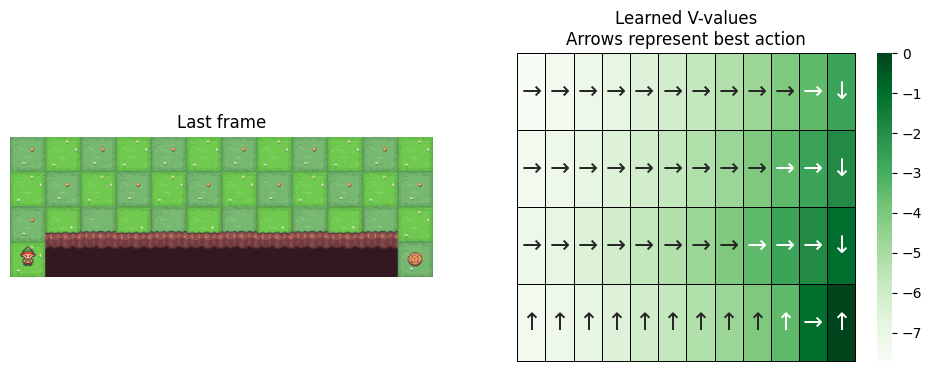

In [38]:
v_directions_map(V, policy, env)

# Model Free

In [39]:
# Epsilon-greedy policy
def eps_greedy(state, q_table, epsilon=0.1):
  action = int(np.argmax(q_table[state]))
  if np.random.random() <= epsilon:
    action = int(env.action_space.sample())
  return action

In [59]:
# Implement Sarsa
def sarsa(num_episodes, alpha=0.1, gamma=0.9):
  q_table = np.zeros((48, 4))
  episode_rewards = []
  for episode in range(num_episodes):
    total_reward = 0
    time_steps = 0
    state, _ = env.reset()
    action = eps_greedy(state, q_table)
    done = False
    while not done:
      next_state, reward, done, trunc, _ = env.step(action)
      next_action = eps_greedy(next_state, q_table)
      q_table[state][action] += alpha * (reward + (gamma * q_table[next_state][next_action]) - q_table[state][action])
      state = next_state
      action = next_action
      total_reward += reward
      time_steps += 1
    episode_rewards.append(total_reward)
    #print("Episode: ", episode, "Time Steps: ", time_steps, "Total Reward: ", total_reward)
  env.close()
  return q_table, episode_rewards

In [66]:
# Implement Q-Learning
def q_learning(num_episodes, alpha=0.1, gamma=0.9):
  q_table = np.zeros((48, 4))
  episode_rewards = []
  for episode in range(num_episodes):
    total_reward = 0
    time_steps = 0
    state, _ = env.reset()
    done = False
    while not done:
      action = eps_greedy(state, q_table)
      next_state, reward, done, trunc, _ = env.step(action)
      q_table[state][action] += alpha * (reward + gamma * np.max(q_table[next_state][:]) - q_table[state][action])
      state = next_state
      total_reward += reward
      time_steps += 1
    episode_rewards.append(total_reward)
    #print("Episode: ", episode, "Time Steps: ", time_steps, "Total Reward: ", total_reward)
  env.close()
  return q_table, episode_rewards

In [42]:
# Display learned Q-values
def qtable_directions_map(q_table):
    qtable_val_max = q_table.max(axis=1).reshape((4, 12))
    qtable_best_action = np.argmax(q_table, axis=1).reshape((4, 12))
    directions = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] != 0.0:
          qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape((4, 12))
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env):
    qtable_val_max, qtable_directions = qtable_directions_map(qtable)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Greens", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

In [63]:
# Run environment with Sarsa
s, s_episode_rewards = sarsa(300)

(48, 4)


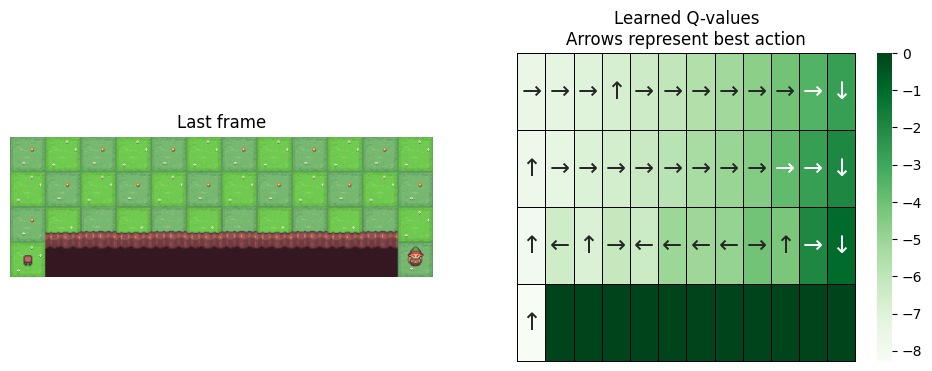

In [64]:
print(s.shape)
plot_q_values_map(s, env)

In [67]:
# Run environment with Q-Learning
q, q_episode_rewards = q_learning(300)

(48, 4)


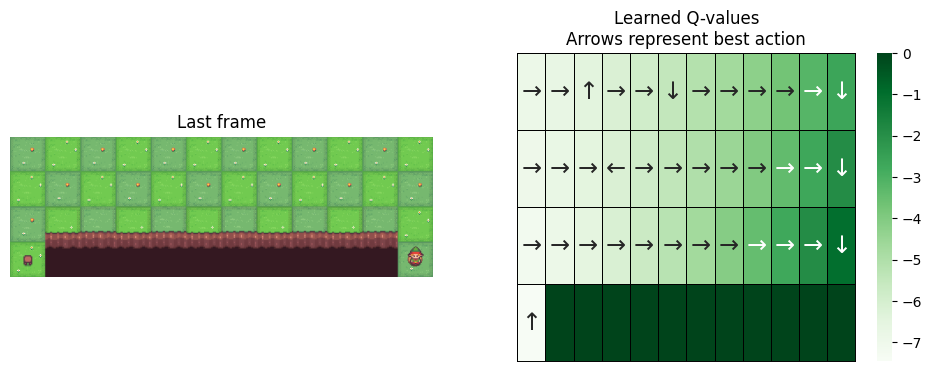

In [55]:
print(q.shape)
plot_q_values_map(q, env)

# Results

In [56]:
# Plot function for model-free
def plot_rewards_f(episode_rewards):
  plt.plot(episode_rewards)
  plt.title("Sum of Rewards per Episode")
  plt.xlabel("Episodes")
  plt.ylabel("Sum of Rewards")
  plt.grid(True)
  plt.show()

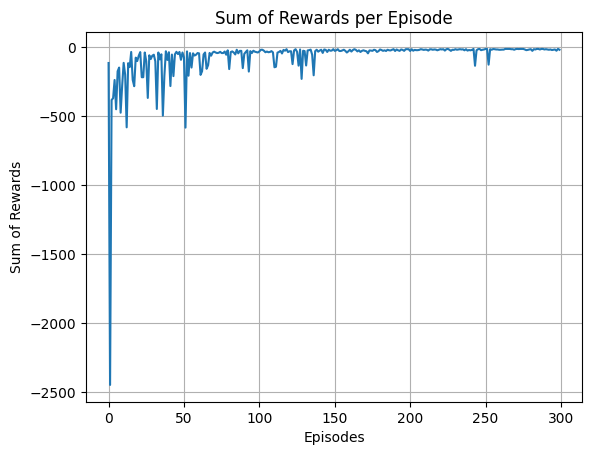

In [57]:
# Plot Sarsa
plot_rewards_f(s_episode_rewards)

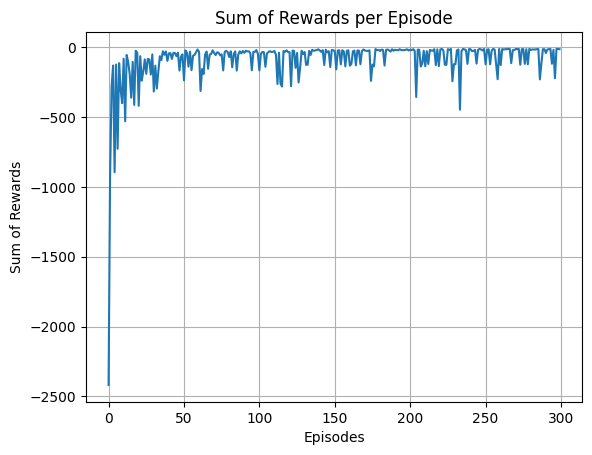

In [58]:
# Plot Q-Learning
plot_rewards_f(q_episode_rewards)